In [1]:
from matplotlib import pyplot as plt
from sklearn import cluster
import numpy as np
import cv2

# отобразить изображение
def imshow(image, ax=plt):
    image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
    ax.imshow(image)
    try:
        ax.ylim(0, image.shape[0])
    except:
        ax.set_ylim(0, image.shape[0])

In [2]:
# загрузка изорбажения, смена цветового пространства с RGB на HSV
image = cv2.imread("test1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
h, w, c = image.shape
colors = [image[:, :, i] for i in range(3)]
force = 200
# двумерный массив с координатами в каждой ячейке, умноженными на коэффициент "силы притяжения", чтобы их учитывала кластеризация, и ближлижащие пиксели с большей вероятностью оказались в одном кластере
forces = np.meshgrid(np.linspace(0, force, w), np.linspace(0, force, h))
# двумерный массив с координатами в каждой ячейке
coords = np.meshgrid(np.linspace(0, w - 1, w, dtype=int), np.linspace(0, h - 1, h, dtype=int))
# двумерный массив конкотенации цветов и сил
total = np.stack(colors + forces, 2)

In [3]:
# кластеризация KMeans, при объявлении 2 кластеров, она чаще всего делит изображение на две части: более светлую и менее, поэтому экспериментальным путём было выяалено, что с 5 или 9 кластерами работает гораздо лучше
_colors = total.reshape((-1, total.shape[-1]))
clt = cluster.KMeans(5)
clt.fit(_colors)

KMeans(n_clusters=5)

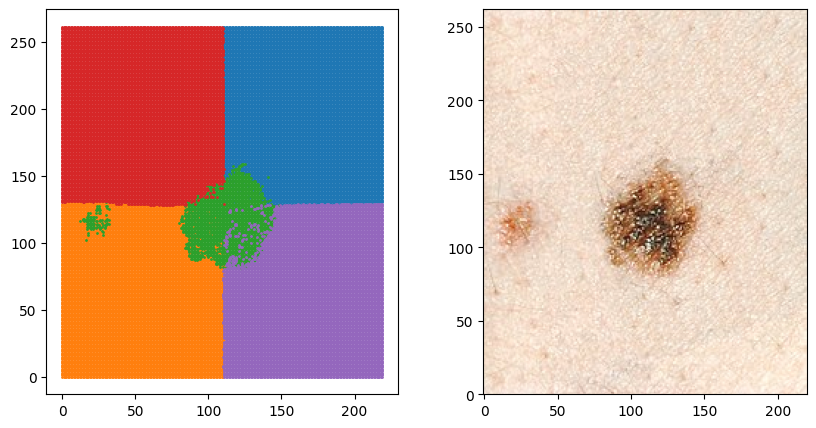

In [4]:
# Узнаем имена всех кластеров 
labels = np.unique(clt.labels_)
cluster_labels = np.reshape(clt.labels_, total.shape[:2]) 

# Создание холста для визуализации кластеров
fig = plt.figure(figsize=(10, 5))
out_clusters, out_image = fig.subplots(1, 2)
cluster_size = []
clusters_data = []
cluster_colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:pink",
    "tab:olive",
    "tab:cyan",
    "lime",
]

class Cluster:
    def __init__(self, image, x, y):
        self.original_image = image
        self.mask = np.zeros_like(image)
        self.mask[y, x] = (255, 255, 255)
        self.average_color = np.mean(image[y, x])
        self.selected_image_part = self.original_image & self.mask
        self.unique_score = None
# Для каждого кластера закрашиваеся изображение в цвет кластера 
clusters: list[Cluster] = []
for label, color in zip(labels, cluster_colors):
    x, y = coords
    cluster_mask = cluster_labels == label
    x = x[cluster_mask]
    y = y[cluster_mask]
    clusters.append(Cluster(image, x, y))
    cluster_image = image[y, x]
    clusters_data.append(cluster_image)
    out_clusters.plot(x, y, "o", markersize=1, color=color)
    cluster_size.append((label, np.count_nonzero(clusters == label)))

imshow(image, out_image)

cluster_size.sort(key=lambda x: x[1], reverse=True)

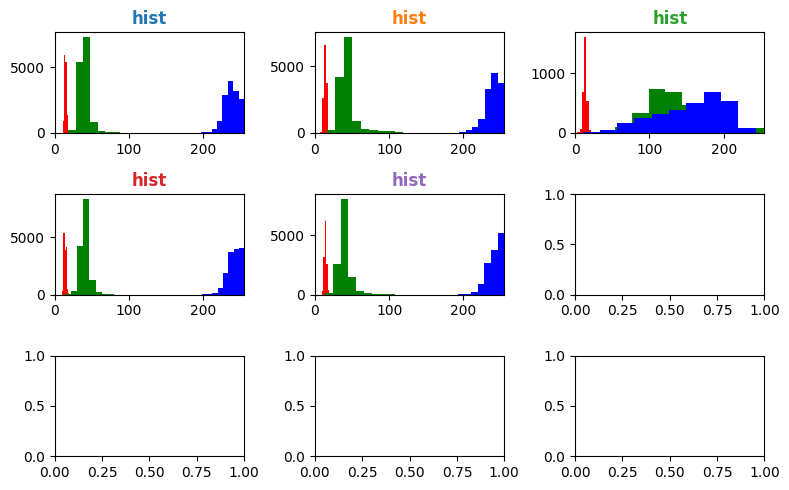

In [5]:
fig = plt.figure(figsize=(8, 5))
subplots = fig.subplots(3, 3).flatten()

# Выводятся гистограммы цветов для бикселей каждого кластера
for subplot, cluster, color in zip(subplots, clusters_data, cluster_colors):
    for i, c in enumerate("rgb"):
        data = np.array(cluster[..., i]).flatten()
        subplot.hist(data, 10, color=c)
    subplot.set_title('hist', color=color, fontweight='bold')
    subplot.set_xlim(0, 255)
fig.tight_layout()

In [6]:
# Тот кластер, гистограмма которого сильнее всех отличается от остальных, и является кластером с родинкой
clusters_mean_colors = np.array([cluster.average_color for cluster in clusters])
clusters_score = []
for cluster in clusters:
    cluster.unique_score = np.sum(np.abs(clusters_mean_colors - cluster.average_color) / 255)
    clusters_score.append(cluster.unique_score)


cluster_of_interest = clusters[np.argmax(clusters_score)]
clusters_score

[0.0339460075266807,
 0.01857586801502845,
 0.05105647627043515,
 0.018743544581924513,
 0.018106636452125378]

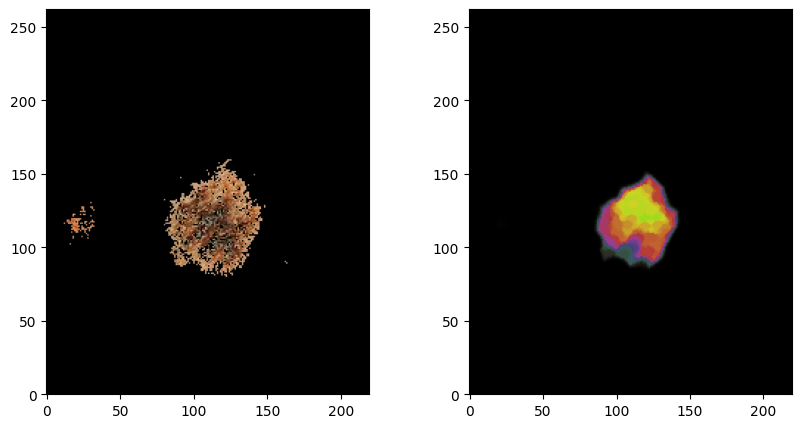

In [7]:
fig = plt.figure(figsize=(10, 5))
out_dominant, out_eroded = fig.subplots(1, 2)
x, y = coords

cluster_of_interest.selected_image_part

imshow(cluster_of_interest.selected_image_part, out_dominant)

erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))
dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))

# Очистка от шума 
cluster_of_interest.mask = cv2.fastNlMeansDenoisingColored(cluster_of_interest.mask, None, 100, 10, 7, 21)
# Применение морфологических трансормаций: сглаживание границ при помощи erode ("обрезка краев" и убирание небольших шумов на изображении) и dilate ("наращивание краев" и восстановление изображения в пределах границ)
cluster_of_interest.mask = cv2.erode(cluster_of_interest.mask, erode_kernel)
cluster_of_interest.mask = cv2.dilate(cluster_of_interest.mask, dilate_kernel)
imshow(cluster_of_interest.mask, out_eroded)

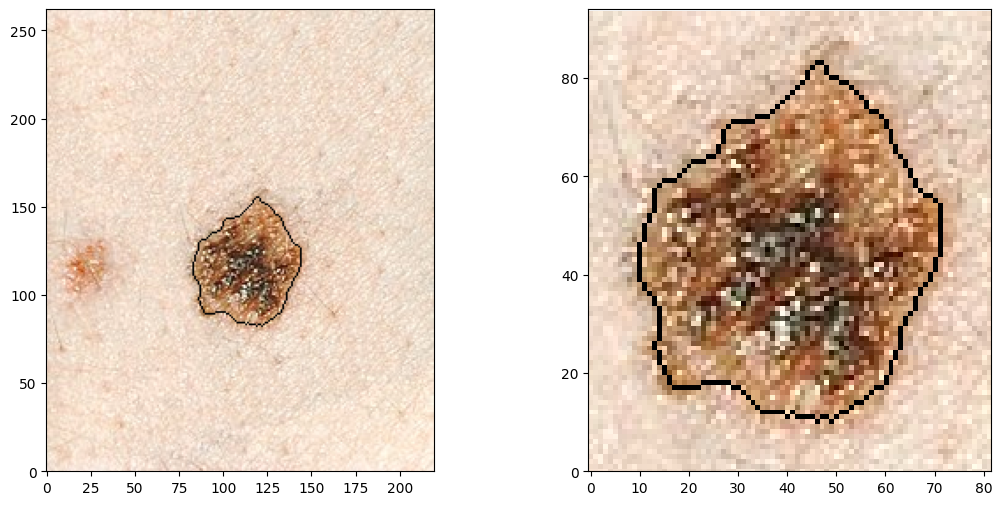

In [8]:
contours_plot, region_plot = plt.figure(figsize=(13, 6)).subplots(1, 2)

# Поиск наибольшего по площади контура на изображении
contours_source = cluster_of_interest.mask[:, :, 0]
contours, hierarchy = cv2.findContours(contours_source, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = [(cnt, cv2.contourArea(cnt)) for cnt in contours]
contours.sort(key=lambda x:x[1], reverse=True)
largest_contour = contours[0][0]
out_contours = cv2.drawContours(np.array(image), [largest_contour], 0, (0,255,0), 1)
imshow(out_contours, contours_plot)

x,y,w,h = cv2.boundingRect(largest_contour)
region_image = out_contours[y-10:y+h+10, x-10:x+w+10, :]
region_contour = largest_contour - np.array([x-10, y-10])
imshow(region_image, region_plot)
region_image = image[y-10:y+h+10, x-10:x+w+10, :]

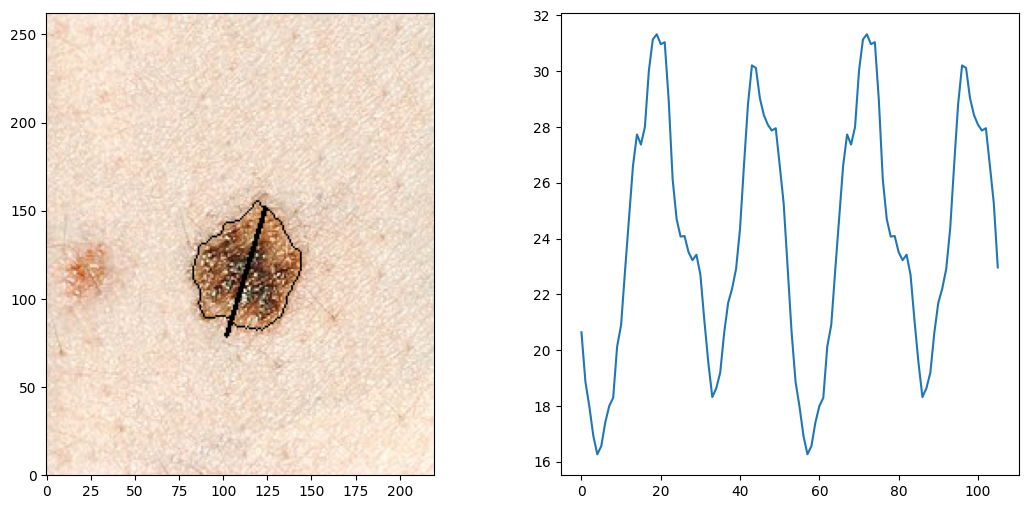

assymetry 16.26998289801885
border 32.57722660653889
color 53.32892330859417
diameter 11.203237152099609


In [10]:
# константа длины пикселя в миллиметрах 
pixelSize = 0.15

# расчёт площади новообразования
area = cv2.contourArea(largest_contour) * (pixelSize ** 2)

M = cv2.moments(largest_contour)

# определение геометрического центра новообразования
center = np.array([int(M['m10']/M['m00']), int(M['m01']/M['m00'])])

cnt_len = largest_contour.shape[0]
scores = []
# для каждой точки в контуре рассчитывается метрика ассиметрии
for i in range(cnt_len):
    current_score = 0
    # от выбранной точки берется левая и правая точки
    for j in range(cnt_len):
        # рассчитывается расстояние до центра, находится разница этих расстояний
        left = (i - j) % cnt_len
        rignt = (i + j) % cnt_len
        ld = np.linalg.norm(largest_contour[left] - center)
        rd = np.linalg.norm(largest_contour[rignt] - center)
        # суммируется модуль разницы всех пар пикселей контура (чем данная сумма меньше, тем более симметричная родинка)
        current_score += abs(ld - rd)
    current_score /= cnt_len * pixelSize
    scores.append(current_score)

# находим индекс точки, у которой сумма разницы модулей расстояния будет минимальна, через данную точку проходит основная ось симметрии
index_min = min(range(len(scores)), key=scores.__getitem__)
assymetry = scores[index_min]

# вывод оси симметрии на изображении
simmetry_plot, assymetry_scores_plot = plt.figure(figsize=(13, 6)).subplots(1, 2)
offset = center - largest_contour[index_min][0]
start = center + offset
end = center - offset
out_simmetry = cv2.line(out_contours, start, end, (0, 0, 0), 2)
imshow(out_simmetry, simmetry_plot)
assymetry_scores_plot.plot(scores)

plt.show()

print("assymetry", assymetry)

# создается маска всей родинки и её границы
mask = np.zeros_like(region_image)
border_mask = cv2.drawContours(np.array(mask), [region_contour], 0, (1, 1, 1), thickness=15)
area_mask = cv2.drawContours(np.array(mask), [region_contour], 0, (1, 1, 1), thickness=cv2.FILLED)

# находится градиент для изображения
gradients = cv2.Laplacian(region_image, cv2.CV_64F)
gradients = np.uint8(np.abs(gradients))

# все значения градиента, которые попадают в маску границы, суммируются и делятся на количество пикселей (чем больше число, тем менее однородна граница родинки)
border_grad = gradients * border_mask
border =  np.sum(border_grad) / np.count_nonzero(border_mask)
print("border", border)

# все значения градиента, которые попадают в маску самой родинки, суммируются и делятся на количество пикселей (чем больше число, тем менее однородна родинка)
area_grad = gradients * area_mask
color = np.sum(area_grad) / np.count_nonzero(area_mask)
print("color", color)

# расчёт радиуса наименьшей описывающей родинку окружности
(x,y),radius = cv2.minEnclosingCircle(largest_contour)
radius *= pixelSize
print("diameter", radius * 2)